# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Config

In [ ]:
# configure = 구성하다

args.d_model = 8  # d_model: model hidden dim
args.n_head = 2  # n_head: multi head attention head number
args.d_head = 4  # d_head: multi head attention head dim
args.dropout = 0.1  # dropout: dropout rate
args.d_ff = 32  # d_ff: feed forward dim
args.norm_eps = 1e-9  # norm_eps: layernormal epsilon
args.n_layer = 6  # n_layer: layer number
args.n_seq = 16  # n_seq: sequence max number
args.n_vocab = 16  # n_vocab: vocab count
args.i_pad = 0  # i_pad: vocab pad id

args

Namespace(d_ff=32, d_head=4, d_model=8, dropout=0.1, i_pad=0, n_head=2, n_layer=6, n_seq=16, n_vocab=16, norm_eps=1e-09, seed=1234)

# Inputs

In [ ]:
# 입력 문장
sentences = [
    ['나는 오늘 행복해', '나도 기분이 매우 좋아'],
    # ['나는 오늘 기분이 좋아', '나도 매우 행복하다'],
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 8,
  '나는': 4,
  '나도': 7,
  '매우': 9,
  '오늘': 5,
  '좋아': 10,
  '행복해': 6},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '행복해',
  7: '나도',
  8: '기분이',
  9: '매우',
  10: '좋아'})

In [ ]:
# train source, target 데이터 생성
train_src_ids, tarin_tgt_ids = [], []
for pair in sentences:
    train_src_ids.append([word_to_id[word] for word in pair[0].split()])
    tarin_tgt_ids.append([word_to_id[word] for word in pair[1].split()])

In [ ]:
train_src_ids, tarin_tgt_ids

([[4, 5, 6]], [[7, 8, 9, 10]])

In [ ]:
# train enc_inputs, dec_inputs, dec_label 생성
train_enc_inputs, train_dec_inputs, train_dec_labels = [], [], []
for source_id, target_id in zip(train_src_ids, tarin_tgt_ids):
    train_enc_inputs.append(source_id)
    train_dec_inputs.append([word_to_id['[BOS]']] + target_id)
    train_dec_labels.append(target_id + [word_to_id['[EOS]']])
train_enc_inputs, train_dec_inputs, train_dec_labels

([[4, 5, 6]], [[2, 7, 8, 9, 10]], [[7, 8, 9, 10, 3]])

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_labels:
    row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_dec_labels

# 일부로 패드 하나씩 넣은거야! 좀따 이용해야지 잇아황을

([[4, 5, 6, 0]], [[2, 7, 8, 9, 10, 0]], [[7, 8, 9, 10, 3, 0]])

In [ ]:
# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_dec_labels = np.array(train_dec_labels)

train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[4, 5, 6, 0]]),
 array([[ 2,  7,  8,  9, 10,  0]]),
 array([[ 7,  8,  9, 10,  3,  0]]))

In [ ]:
args.n_vocab = len(word_to_id)
args.n_seq = 6

args

Namespace(d_ff=32, d_head=4, d_model=8, dropout=0.1, i_pad=0, n_head=2, n_layer=6, n_seq=6, n_vocab=11, norm_eps=1e-09, seed=1234)

In [ ]:
# embedding with random weight
embed_weight = np.random.randint(-90, 100, (args.n_vocab, args.d_model)) / 100

embed = tf.keras.layers.Embedding(args.n_vocab, args.d_model, weights=[embed_weight]) # 위에 설정한 weight로 초기값을 시작할려고
embed_weight

array([[-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67],
       [ 0.64, -0.6 ,  0.81,  0.68,  0.34, -0.64,  0.28,  0.96],
       [ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
       [-0.53, -0.56,  0.76,  0.49,  0.38, -0.15, -0.1 , -0.87],
       [-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
       [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
       [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
       [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
       [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
       [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
       [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93]])

In [ ]:
train_enc_inputs.shape,train_dec_inputs.shape

((1, 4), (1, 6))

In [ ]:
# encoder hidden
hidden_enc = embed(train_enc_inputs)
hidden_enc

<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>

In [ ]:
# decoder hidden
hidden_dec = embed(train_dec_inputs)
hidden_dec

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>

# Mask

## PAD Mask

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    # 0인 부분 확인
    mask = tf.math.equal(tokens, i_pad) # 0과 같은걸 true => padding을 True하겟다라는 말
    # boolean -> float 32
    mask = tf.cast(mask, tf.float32)
    # expand dimension for n_seq
    mask = tf.expand_dims(mask, axis=1) #( 1,4) -> (1,1,4)로 만들게, 브로드케스팅 이용하려고
    # print(mask)
    return mask

In [ ]:
enc_pad_mask = get_pad_mask(train_enc_inputs)
enc_pad_mask

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>

## Causal Mask

In [ ]:
def get_causal_mask(tokens, i_pad=0):
    """
    causal mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: causal and pad mask (causal or pad: 1, other: 0)
    """
    # 개수 조회
    n_seq = tf.shape(tokens)[1]
    # make ahead mask
    mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    print(mask)
    # expand dim for bs
    mask = tf.expand_dims(mask, axis=0)
    print(mask)
    # get pad_mask
    pad_mask = get_pad_mask(tokens, i_pad)
    # mask all ahead_mask or pad_mask
    mask = tf.maximum(mask, pad_mask)
    print(mask)
    return mask

In [ ]:
dec_causal_mask = get_causal_mask(train_dec_inputs)
dec_causal_mask

tf.Tensor(
[[0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]], shape=(6, 6), dtype=float32)
tf.Tensor(
[[[0. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0.]]], shape=(1, 6, 6), dtype=float32)
tf.Tensor(
[[[0. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]], shape=(1, 6, 6), dtype=float32)


<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# dec_causal_mask = get_causal_mask(np.array([[1,2,3,0,0,0]]))
# dec_causal_mask

In [ ]:
train_dec_inputs

array([[ 2,  7,  8,  9, 10,  0]])

## Mask 생성

In [ ]:
# Encoder Self Attetnion mask
enc_self_mask = get_pad_mask(train_enc_inputs)
enc_self_mask

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# Decoder Self Attetnion mask
dec_self_mask = get_causal_mask(train_dec_inputs)
dec_self_mask

tf.Tensor(
[[0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]], shape=(6, 6), dtype=float32)
tf.Tensor(
[[[0. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0.]]], shape=(1, 6, 6), dtype=float32)
tf.Tensor(
[[[0. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]], shape=(1, 6, 6), dtype=float32)


<tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
# Encoder-Decoder Attetnion mask
enc_dec_mask = get_pad_mask(train_enc_inputs)
enc_dec_mask

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>

# Scaled dot product attention

In [ ]:
# Encoder의 self attention

class ScaleDotProductAttention(tf.keras.layers.Layer): # 이 레이어의 성격을 가진 새로운 scale dot attention을 만들려한다
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name) # name이 바뀌는거지

    def call(self, inputs): # 호출된다!
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        print(inputs)
        # matmul Q, K (transpose_b=True)
        attn_score = tf.matmul(Q, K, transpose_b=True) # score 값 구해야지! # Q와 k.T의 곱이 된거지
        print(attn_score)
        # get scale = d_model ** 0.5
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32)) # 8에 루트를 해서 dk인 scale 값 만들어주는거지 (bs , n_seq, d_model) # 위에서 설정한 d_model가 dk가 되는거고 그거에 root를 씌우는거지
        print(scale)
        # divide by scale
        attn_scale = tf.math.divide(attn_score, scale) # dk를 나눠줬으니까 편차가 줄어들었지!
        print(attn_scale)
        # do mask (subtract 1e-9 for masked value)
        attn_scale -= 1.e9 * attn_mask # -무한대를 생성해준거지!
        print(attn_scale)
        # calculate attention prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        print(attn_prob) # padding이 0값이 됬는지 확인해보자고
        # weighted sum of V
        attn_out = tf.matmul(attn_prob, V) # 확률분포 다 구해줬으니까 다시 v랑 곱해줘야지!
        print(attn_out)
        return attn_out

In [ ]:
# Encoder Self Attetnion
Q = hidden_enc
K = hidden_enc
V = hidden_enc


attention = ScaleDotProductAttention()
attn_out = attention((Q, K, V, enc_self_mask)) # input이 4개의 tuple이지
attn_out

# Q와 k.T의 곱이 된거지
# (1,4,8)
# 8에 루트를 해서 dk인 scale 값 만들어주는거지
# 4번째부터 거의 0이네!

(<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
  

<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.33673763, -0.14718404,  0.28105342,  0.12895234,
         -0.13027158, -0.59879863, -0.29280293,  0.13225272],
        [ 0.38699383,  0.4663373 ,  0.02351167,  0.00184637,
         -0.52675986, -0.21546207, -0.17166461,  0.23066413],
        [ 0.15688345,  0.3411215 ,  0.08789635,  0.02475113,
         -0.4025072 , -0.423769  , -0.2673669 ,  0.12314419],
        [-0.0894036 ,  0.0593639 ,  0.19382112,  0.0862966 ,
         -0.2656899 , -0.46393138, -0.24884827,  0.16929165]]],
      dtype=float32)>

In [ ]:
# Decoder Self Attetnion
Q = hidden_dec
K = hidden_dec
V = hidden_dec

attn_out = attention((Q, K, V, dec_self_mask))
attn_out

# qxk값
# dk의 scale값
# qxk의 편자가 줄어든걸 확인할수 있지
# mask 씌울게 첫번째 인덱스는 2번째부터 바로 마스크 되네
# 위에 mask 씌워진 x값을 softmax하는거지 => padding이 제거된걸 알수 있지
# 마지막 출력이 ㅜ머엿지? => softmax랑 v 랑 곱하는거엿지

(<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
arra

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3       ,  0.22      , -0.21      , -0.1       ,
          0.37      ,  0.85      , -0.4       , -0.14      ],
        [ 0.8220094 , -0.12256869,  0.7279856 , -0.05106161,
          0.73703784, -0.19401884,  0.6358624 , -0.613071  ],
        [ 0.2558922 ,  0.44485563, -0.13420665,  0.05789444,
          0.0157903 ,  0.3860917 ,  0.27768278, -0.40479344],
        [ 0.3199534 ,  0.59821546,  0.28575277, -0.27999634,
         -0.333703  , -0.17342496, -0.30924594, -0.24398847],
        [ 0.25748828,  0.2539822 , -0.08660144, -0.11142017,
          0.2383957 ,  0.47562987, -0.13635282,  0.15004346],
        [ 0.3563357 ,  0.25620973,  0.06082512, -0.06005869,
          0.23631345,  0.29513738,  0.11814437, -0.14325687]]],
      dtype=float32)>

In [ ]:
# Encoder-Decoder Attetnion
Q = hidden_dec
K = hidden_enc
V = hidden_enc

attn_out = attention((Q, K, V, enc_dec_mask))
attn_out

# decoder hidden (1,6,8)
# encoder (1,4,8) 2개

# q x k하면 행렬나오고
# 2.8값인 scale로 나눠주니까
# 편차가 줄어든게 보이는거지
# -무한대로
# softmax걸고 
# v 다시 곱하면 (1,6,4) = soft(qxk) 에서  v.T=(4,8) 곱하니까 (1,6,8)이 되는거지

(<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
    

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.19251837,  0.31496453,  0.08933708,  0.03262058,
         -0.42056832, -0.33515704, -0.21525805,  0.18950062],
        [ 0.03015198,  0.18805543,  0.14442684,  0.05844635,
         -0.33189586, -0.43443522, -0.25122088,  0.15571064],
        [ 0.280768  ,  0.4016145 ,  0.05496714,  0.01415424,
         -0.4692218 , -0.30306178, -0.21017894,  0.18858087],
        [ 0.19713108,  0.37910423,  0.07260605,  0.01671409,
         -0.42465654, -0.4072318 , -0.26379353,  0.12440023],
        [ 0.15545696,  0.25524265,  0.10961668,  0.04622392,
         -0.39953092, -0.3197682 , -0.19828974,  0.21534915],
        [-0.0894036 ,  0.0593639 ,  0.19382112,  0.0862966 ,
         -0.2656899 , -0.46393138, -0.24884827,  0.16929165]]],
      dtype=float32)>

# Multi Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, args, name="multi_head_attention"): # 초기값은 args를 참조
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = args.d_model # 저장
        self.n_head = args.n_head # 저장
        self.d_head = args.d_head # 저장

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(self.n_head * self.d_head) 
        self.W_K = tf.keras.layers.Dense(self.n_head * self.d_head)
        self.W_V = tf.keras.layers.Dense(self.n_head * self.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(self.d_model) # 나중에 최종 ouput이 d_model이어야 되니까

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        print(inputs)
        # Q_m = self.W_Q(Q) # Q = (bs,q_seq, d_model) -> (bs, q_seq, n_head * d_head)
        # print(Q_m)
        # Q_m = tf.reshape(Q_m,[-1, tf.shape(Q)[1], self.n_head, self.d_head]) # (bs, q_Seq, n_head, d_head) # 음 8개가 4,4로 나눠졋네
        # print(Q_m)
        # Q_m = tf.transpose(Q_m, [0,2,1,3]) # (bs, n_head, q_seq, d_head)
        # print(Q_m) # 조그만한 shape으로 만들었지, concat할 귀여운 것들

        
        # build multihead Q, K, V
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [-1, tf.shape(Q)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [-1, tf.shape(K)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [-1, tf.shape(V)[1], self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        
        # build multihead mask
        attn_mask_m = tf.expand_dims(attn_mask, axis=1) # mask의 위치를 차원 하나 늘려주고
        print(attn_mask_m)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out_m = self.attention((Q_m, K_m, V_m, attn_mask_m))  # (bs, n_head, Q_len, d_head) # 조그매진 싸이즈로 attention해준거야
        print(attn_out_m)
        
        # transpose and reshape
        attn_out_t = tf.transpose(attn_out_m, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head) # (인덱스를 0,2,1,3,)순수러 바꾸라는거지 =? (1,4,2,4)
        print(attn_out_t)

        attn_out_c = tf.reshape(attn_out_t, [-1, tf.shape(Q)[1], self.n_head * self.d_head])  # (bs, Q_len, d_model) (1,4,8) # 보통 batchsize를 -1로 주는게 안전함 tf에서는
        print(attn_out_c) # 하나가 되어버렷구나/ 다시 원래 shape으로
        # linear for output
        attn_out = self.W_O(attn_out_c) # (bs, Q_len, d_model) 마지막으로 W를 굽해주면 된다
        print(attn_out)
        return attn_out

In [ ]:
# Encoder Self Attetnion
Q = hidden_enc
K = hidden_enc
V = hidden_enc

attention = MultiHeadAttention(args)
attn_out = attention((Q, K, V, enc_self_mask))
attn_out



(<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
  

<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[ 0.10311627, -0.17242327, -0.47007337, -0.25791693,
          0.11060909, -0.5176323 ,  0.34612116, -0.11488531],
        [ 0.25805393, -0.1964328 , -0.15741327, -0.07166203,
          0.09478772, -0.4113168 ,  0.1282831 ,  0.0436722 ],
        [ 0.24377878, -0.19456774, -0.3927982 , -0.12195265,
          0.17183077, -0.5609013 ,  0.22354789, -0.04812689],
        [-0.05719034, -0.07377674, -0.30321503, -0.38978112,
         -0.16849314, -0.11543342,  0.41965896, -0.06162873]]],
      dtype=float32)>

In [ ]:
# Decoder Self Attetnion
Q = hidden_dec
K = hidden_dec
V = hidden_dec

attn_out = attention((Q, K, V, dec_self_mask))
attn_out

(<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
arra

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[-0.19374582, -0.08686735,  0.5888069 ,  0.12967204,
         -0.5593776 ,  0.7996789 , -0.6087034 ,  0.19019793],
        [-0.69766843, -0.08384632,  0.44873366,  0.31499898,
          0.16652524,  0.29853705, -0.36443794, -0.27150342],
        [-0.38272467,  0.02500083,  0.5222409 ,  0.04887583,
         -0.0077721 ,  0.14305574, -0.34306738,  0.04870466],
        [-0.38885254, -0.11416872,  0.34811124, -0.06686896,
          0.24592713, -0.32135135, -0.02894916, -0.06843521],
        [-0.15142328, -0.18819407,  0.2216553 ,  0.08119921,
         -0.09086338,  0.15225199, -0.14843561, -0.00134463],
        [-0.05574143, -0.21956405,  0.21678054,  0.11254357,
         -0.23511295,  0.3327807 , -0.22084998,  0.03987915]]],
      dtype=float32)>

In [ ]:
# Encoder-Decoder Attetnion
Q = hidden_dec
K = hidden_enc
V = hidden_enc

attn_out = attention((Q, K, V, enc_dec_mask))
attn_out

(<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
    

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.06879989, -0.13136551, -0.29640925, -0.27237612,
         -0.0284498 , -0.3176212 ,  0.29824704, -0.03291269],
        [-0.04851327, -0.126137  , -0.32618463, -0.36235318,
         -0.08135401, -0.17502446,  0.46783108, -0.1222997 ],
        [ 0.12572524, -0.173893  , -0.29386657, -0.206309  ,
          0.05486511, -0.37810507,  0.29027176, -0.05298389],
        [ 0.29829973, -0.20293026, -0.46590918, -0.08472198,
          0.23182899, -0.6372739 ,  0.22040558, -0.06377728],
        [ 0.08620396, -0.1206386 , -0.19071527, -0.24937308,
         -0.07298145, -0.27256894,  0.2181598 ,  0.03407099],
        [-0.05719034, -0.07377674, -0.30321503, -0.38978112,
         -0.16849314, -0.11543342,  0.41965896, -0.06162873]]],
      dtype=float32)>

# Feed Forward

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, args, name="feed_forward"):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(args.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(args.d_model) # d_ff 로 커진 걸 다시 원래대로 d_model로 돌아오게 하는거지

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        # print(inputs)
        # linear W_1 and W_2
        ff_val = self.W_1(inputs) # 4배 펌핑
        # print(ff_val)
        ff_val = self.W_2(ff_val) # 다시 1배로 수축
        # print(ff_val)
        return ff_val

In [ ]:
# feed-forward class 동작 확인
feed_forward = PositionWiseFeedForward(args)
ff_val = feed_forward(hidden_enc) 
ff_val.shape

tf.Tensor(
[[[-0.88 -0.71  0.5   0.25  0.17 -0.76 -0.3   0.17]
  [ 0.84  0.66 -0.09 -0.03 -0.77  0.26  0.06  0.5 ]
  [ 0.23  0.69 -0.01 -0.06 -0.45 -0.74 -0.49 -0.18]
  [-0.43 -0.52 -0.37  0.26  0.62  0.53  0.87 -0.67]]], shape=(1, 4, 8), dtype=float32)
tf.Tensor(
[[[0.13454776 0.         0.         0.44186082 0.28136936 0.04193079
   0.3432111  0.         0.         0.5837846  0.         0.
   0.08552394 0.         0.         0.6507844  0.         0.
   0.415635   0.         0.         0.         0.3480382  0.37178615
   0.04553471 0.         0.         0.         0.         0.
   0.         0.        ]
  [0.20565188 0.30634147 0.05324171 0.         0.         0.24230781
   0.         0.73866534 0.24382249 0.         0.06559308 0.39371055
   0.12448631 0.33017614 0.         0.         0.         0.5500289
   0.         0.2344925  0.25503403 0.540465   0.         0.
   0.42051074 0.05549175 0.4164435  0.2362547  0.18483028 0.
   0.         0.01112419]
  [0.13941848 0.36088312 0.0186000

TensorShape([1, 4, 8])

# LayerNormal
- https://arxiv.org/abs/1607.06450

In [ ]:
# 큰 hidden 생성
hidden = np.array([[1, 2, 3],
                   [11, 22, 33],
                   [111, 222, 333]]).astype(np.float32)
hidden

array([[  1.,   2.,   3.],
       [ 11.,  22.,  33.],
       [111., 222., 333.]], dtype=float32)

In [ ]:
# layer_normal 실행
layer_norm = tf.keras.layers.LayerNormalization()
layer_norm(hidden)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-1.2238274,  0.       ,  1.2238274],
       [-1.2247372,  0.       ,  1.2247372],
       [-1.2247448,  0.       ,  1.2247448]], dtype=float32)>

In [ ]:
# weights
layer_norm.get_weights() # layer normal도 weight가 있다! 정도만.. => 학습되면 바뀌겟지

[array([1., 1., 1.], dtype=float32), array([0., 0., 0.], dtype=float32)]

In [ ]:
# 평균 값
mean = np.mean(hidden, axis=-1, keepdims=True) # 디맨션을 유지해라는거지
mean

array([[  2.],
       [ 22.],
       [222.]], dtype=float32)

In [ ]:
# sqrt(var - epsiolon)
sigma = np.sqrt(np.var(hidden, axis=-1, keepdims=True) + 0.001)
sigma

array([[ 0.81710875],
       [ 8.981518  ],
       [90.63113   ]], dtype=float32)

In [ ]:
# layer normal 계산
(hidden - mean) / sigma

array([[-1.2238274,  0.       ,  1.2238274],
       [-1.2247373,  0.       ,  1.2247373],
       [-1.2247448,  0.       ,  1.2247448]], dtype=float32)

# Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, args, name='encoder_layer'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(args)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps) # 0 방지를 위해서

        self.ffn = PositionWiseFeedForward(args)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.dropout = tf.keras.layers.Dropout(args.dropout)
 
    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_hidden, self_mask tuple
        :return enc_out: EncoderLayer 실행 결과
        """
        # print(inputs)

        enc_hidden, self_mask = inputs
        # self attention
        self_attn_val = self.self_attention((enc_hidden, enc_hidden, enc_hidden, self_mask)) # Q,K,V mask해서 
        # print(self_attn_val) # self_encoder-attention의 output
        
        # add and layer normal
        norm1_val = self.norm1(enc_hidden + self.dropout(self_attn_val)) # residual과 dropout을 건거를 더해줘서 normalize한거
        # print(norm1_val)
        
        # feed forward
        ffn_val = self.ffn(norm1_val) # feed forward의 output
        # print(ffn_val)
        
        # add and layer normal
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val)) # feed forward 의 output과 dropout을 더해서 norm한거!

        return enc_out

In [ ]:
# EncoderLayer 기능 확인
encoder_layer = EncoderLayer(args)
enc_out = encoder_layer((hidden_enc, enc_self_mask))
# enc_out # 인코더 hidden과 mask
enc_out.shape

(<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0., 0., 0., 1.]]], dtype=float32)>)
(<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.45, -0.74, -0.49, -0.18],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[-0.88, -0.71,  0.5 ,  0.25,  0.17, -0.76, -0.3 ,  0.17],
        [ 0.84,  0.66, -0.09, -0.03, -0.77,  0.26,  0.06,  0.5 ],
        [ 0.23,  0.69, -0.01, -0.06, -0.

TensorShape([1, 4, 8])

# Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, args, name='decoder_layer'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(args)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.ende_attn = MultiHeadAttention(args)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.ffn = PositionWiseFeedForward(args)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=args.norm_eps)

        self.dropout = tf.keras.layers.Dropout(args.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: dec_hidden, enc_out, self_mask, ende_mask tuple
        :return dec_out: DecoderLayer 실행 결과
        """
        # print(inputs)
        dec_hidden, enc_out, self_mask, ende_mask = inputs
        # self attention
        self_attn_val = self.self_attention((dec_hidden, dec_hidden, dec_hidden, self_mask)) # decoder self attention의 결과
        # add and layer normal
        norm1_val = self.norm1(dec_hidden + self.dropout(self_attn_val)) # q랑 더하는거지

        # encoder and decoder attention
        ende_attn_val = self.ende_attn((norm1_val, enc_out, enc_out, ende_mask)) #  Q, V ,K순서
        # add and layer normal
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val)) # encoder_ decoder의 attention의 output에 dropout,residual 마무리로 normalization

        # feed forward
        ffn_val = self.ffn(norm2_val) # feed forward에 en_de_attention_norm을 넣은거지
        # add and layer normal
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val)) # 그걸 다시 dropout하고 residual 하고 마지막으로 norm

        return dec_out

In [ ]:
# Decoder 실행
decoder_layer = DecoderLayer(args)
dec_out = decoder_layer((hidden_dec, enc_out, dec_self_mask, enc_dec_mask)) # mastk 2개
# dec_out.shape
dec_out

(<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.3 ,  0.22, -0.21, -0.1 ,  0.37,  0.85, -0.4 , -0.14],
        [ 0.94, -0.2 ,  0.94, -0.04,  0.82, -0.43,  0.87, -0.72],
        [-0.05,  0.84, -0.53,  0.19, -0.52,  0.45,  0.43, -0.43],
        [ 0.28,  0.85,  0.53, -0.56, -0.8 , -0.62, -0.86, -0.08],
        [ 0.13, -0.01, -0.35, -0.12,  0.61,  0.88, -0.28,  0.93],
        [-0.43, -0.52, -0.37,  0.26,  0.62,  0.53,  0.87, -0.67]]],
      dtype=float32)>, <tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
arra

<tf.Tensor: shape=(1, 6, 8), dtype=float32, numpy=
array([[[ 0.658353  ,  0.5355427 , -0.9519356 , -1.3525977 ,
          1.4077446 ,  0.46428075, -1.3948205 ,  0.63343275],
        [ 0.4084364 , -1.9003108 ,  0.31852826,  0.64919317,
          0.44116393, -1.1450069 ,  1.4623591 , -0.23436299],
        [-0.9762897 ,  0.6589331 , -0.6992875 ,  1.2054019 ,
         -1.4596894 , -0.70961756,  1.1840928 ,  0.7964562 ],
        [ 0.99005485,  0.13705453,  0.73175013,  0.2692972 ,
         -1.4024172 , -1.4387537 , -0.6686876 ,  1.3817016 ],
        [-0.19098887, -0.18113773, -0.9157462 , -1.1452663 ,
          0.30609655,  0.68378484, -0.7236625 ,  2.1669202 ],
        [-0.9667267 , -1.2933204 , -0.7397968 ,  0.7365178 ,
          0.7298252 , -0.23633894,  1.9213407 , -0.15150076]]],
      dtype=float32)>

# Weight Shared Embedding

In [ ]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, args, name='weight_shared_embedding'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = args.n_vocab
        self.d_model = args.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope('shared_embedding_weight'):
            self.shared_weights = self.add_weight(  # weight를 share 할게!
                'weights',
                shape=[self.n_vocab, self.d_model], # 이러한 shape을 가지로
                initializer=tf.keras.initializers.TruncatedNormal(stddev=self.d_model ** -0.5) # initialize를 표준편차를 줄여놓고
            )

    def call(self, inputs, mode='embedding'): # mode가 있넴? # 기본은 embedding으로 되어잇네
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # print(mode)

        # mode가 embedding일 경우 embedding lookup 실행
        if mode == 'embedding':
            return self._embedding(inputs)
        
        # mode가 linear일 경우 linear 실행
        elif mode == 'linear':
            return self._linear(inputs)
        
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f'mode {mode} is not valid.')
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        # lookup by gather

        # print(self.shared_weights)
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32)) # share_weight에서 gather하니까 # 혹시나모를 error 때문에 cast로 강제한거고
        # print(inputs)
        # print(embed)
        # muliply d_model ** 0.5
        embed *= self.d_model ** 0.5 # 다시 size를 표준편차때 줄여놨던걸 키운거지!
        # print(embed)
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        # matmul inputs, shared_weights (transpose_b=True)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        return outputs

In [ ]:
# weight = np.random.rand(8,5) # vocab, d_model
# weight


In [ ]:
# tf.gather(weight, [0,2,4,6])
# # 아하 weight에서 0,2,4,6 번째만 꺼내오는거구나

In [ ]:
embedding = SharedEmbedding(args)
hidden_dec = embedding(train_dec_inputs)
hidden_dec.shape

TensorShape([1, 6, 8])

In [ ]:
linear_outputs = embedding(hidden_dec, mode="linear")
linear_outputs.shape

TensorShape([1, 6, 11])

# Postional Encoding

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer): # embedding이지만 실제론 encoding이래
    """
    Positional Embedding Class
    """
    def __init__(self, args, name='position_embedding'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(args.n_seq, args.d_model) # sin,cos으로된 encoding
        self.embedding = tf.keras.layers.Embedding(args.n_seq, args.d_model, trainable=False, weights=[pos_encoding]) # 꺼내오고 학습하지 않겠따 그리고 그거를 embedding으로 쓰겠다!
        
        # self.embedding = tf.keras.layers.Embedding(args.n_seq, args.d_model) #  요즘엔 position embedding을 쓰는 경우도 많음
    
    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        # make position (0...n_seq)
        position = tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True) #(1,2,3,4) -> (0,1,2,3)으로 하나씩 뒤로 미는거지
        position = tf.cast(position, tf.int32)
        # embedding lookup
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model):
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        # calculate angle
        exs = [2 * (i // 2) / d_model for i in range(d_model)] # i가 돌아가면서 d_moel 차원으로 만들어졌지
        # print(exs)
        # print(d_model)
        angles = [np.power(10000, ex) for ex in exs] # 10000의 승으로 올려버릴게
        # print(angles)
        
        # calculate position
        pos_encoding = np.array([[pos / angle for angle in angles] for pos in range(n_seq)])
        # print(pos_encoding)
        
        # sin even number // 짝수는 sin
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2]) # 0부터 2칸씩

        # cos odd number
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2]) # 1부터 2칸씩
        return tf.cast(pos_encoding, tf.float32)

In [ ]:
# position encoding 확인
pos_encoding = PositionalEmbedding.get_sinusoid_encoding(8, 8)
pos_encoding

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  5.4030228e-01,  9.9833414e-02,  9.9500418e-01,
         9.9998331e-03,  9.9994999e-01,  9.9999981e-04,  9.9999952e-01],
       [ 9.0929741e-01, -4.1614684e-01,  1.9866933e-01,  9.8006660e-01,
         1.9998666e-02,  9.9980003e-01,  1.9999987e-03,  9.9999797e-01],
       [ 1.4112000e-01, -9.8999250e-01,  2.9552022e-01,  9.5533651e-01,
         2.9995501e-02,  9.9955004e-01,  2.9999956e-03,  9.9999553e-01],
       [-7.5680250e-01, -6.5364361e-01,  3.8941833e-01,  9.2106098e-01,
         3.9989334e-02,  9.9920011e-01,  3.9999895e-03,  9.9999201e-01],
       [-9.5892429e-01,  2.8366220e-01,  4.7942555e-01,  8.7758255e-01,
         4.9979169e-02,  9.9875027e-01,  4.9999794e-03,  9.9998748e-01],
       [-2.7941549e-01,  9.6017027e-01,  5.6464249e-01,  8.2533562e-01,
         5

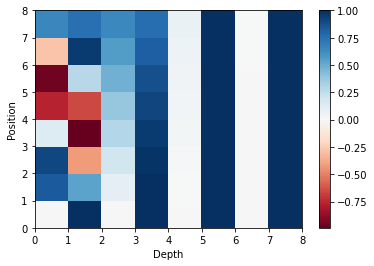

In [ ]:
# display
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, args.d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
position = tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True)
position = tf.cast(position, tf.int32)        

NameError: ignored

In [ ]:
tf.math.cumsum(tf.ones_like(train_enc_inputs),axis = 1, exclusive=True)

In [ ]:
# PositionalEmbedding 클래스 시험
pos_embedding = PositionalEmbedding(args)
dec_pos = pos_embedding(train_enc_inputs)
dec_pos.shape

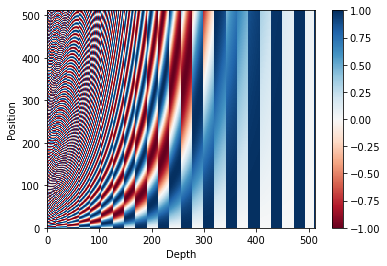

In [ ]:
# 512x512 position encoding table 생성
pos_encoding = PositionalEmbedding.get_sinusoid_encoding(512, 512)
# display
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Transformer

In [ ]:
class Transformer(tf.keras.Model):
    """
    Transformer Class
    """
    def __init__(self, args, name='transformer'):
        """
        생성자
        :param args: Args 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = args.i_pad
        self.embedding = SharedEmbedding(args)
        self.position = PositionalEmbedding(args) # position vector
        
        self.encoder_layers = [EncoderLayer(args, name=f'encoder_layer_{i}') for i in range(args.n_layer)] # n_layer를 6으로 줄게
        # print(self.encoder_layers)
        self.decoder_layers = [DecoderLayer(args, name=f'decoder_layer_{i}') for i in range(args.n_layer)]
        # print(self.decoder_layers)

        self.dropout = tf.keras.layers.Dropout(args.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: enc_tokens, dec_tokens tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs
        # print(inputs)
        # encoder self attention mask
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad) # encoder 는 pad mask
        # decoder self attention mask
        dec_self_mask = get_causal_mask(dec_tokens, self.i_pad) # decoder는 casual mask
        # encoder and decoder attention mask
        enc_dec_mask = get_pad_mask(enc_tokens, self.i_pad) # 둘다는 pad mask

        # enc_tokens, dec_tokens embedding lookup
        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        # dropout for enc_embed
        enc_hidden = self.dropout(enc_embed)
        # call encoder layers

        print(self.encoder_layers)
        for encoder_layer in self.encoder_layers:
            enc_hidden = encoder_layer((enc_hidden, enc_self_mask)) # 6번 반복
        
        # dropout for dec_embed
        dec_hidden = self.dropout(dec_embed)

        # call decoder layers
        for decoder_layer in self.decoder_layers: # 이것도 6번 반복
            dec_hidden = decoder_layer((dec_hidden, enc_hidden, dec_self_mask, enc_dec_mask))

        # call weight shared embedding (model=linear)
        logits = self.embedding(dec_hidden, mode='linear')
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        # print(self.embedding(tokens))
        # print(self.position(tokens))

        embed = self.embedding(tokens) + self.position(tokens)
        return embed

In [ ]:
# Transformer 기능 확인. 최종 결과가 (bs, n_seq(dec), n_vocab)
transformer = Transformer(args)
logits = transformer((train_enc_inputs, train_dec_inputs))
# logits.shape

# 지금 다른 classs에서 print()가 안지워져서 오류나는거임

tf.Tensor(
[[0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]], shape=(6, 6), dtype=float32)
tf.Tensor(
[[[0. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0.]]], shape=(1, 6, 6), dtype=float32)
tf.Tensor(
[[[0. 1. 1. 1. 1. 1.]
  [0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]], shape=(1, 6, 6), dtype=float32)
ListWrapper([<__main__.EncoderLayer object at 0x7f1d02adbfd0>, <__main__.EncoderLayer object at 0x7f1d02a3ec50>, <__main__.EncoderLayer object at 0x7f1d02aff710>, <__main__.EncoderLayer object at 0x7f1d02b2e110>, <__main__.EncoderLayer object at 0x7f1d02a65cd0>, <__main__.EncoderLayer object at 0x7f1d02a44150>])
(<tf.Tensor: shape=(1, 4, 8), dtype=float32, numpy=
array([[[ 0.9763168 ,  1.623848  ,  1.3322731 ,  1.4846188 ,
         -1.2604036 ,  0.37468475, -0.08113289,  